# 1. Basic Setup

In [ ]:
# mediapipe: Able to get keypoints from the body
# scikit-learn: Tools for predictive data analysis

In [2]:
pip install tensorflow opencv-python matplotlib mediapipe scikit-learn


  Using cached mediapipe-0.10.21-cp310-cp310-win_amd64.whl.metadata (10 kB)
INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
  Using cached tensorflow-2.20.0-cp310-cp310-win_amd64.whl.metadata (4.6 kB)
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/375.7 MB ? eta -:--:--
   -----

In [30]:
import cv2
import os
import time
import numpy as np
from matplotlib import pyplot as plt
import mediapipe as mp

# 2. Keypoints using MP

In [35]:
mp_holistic = mp.solutions.holistic # Make detections (pose, hands, face etc.)
mp_drawing = mp.solutions.drawing_utils # Draw keypoints
mp_face_mesh = mp.solutions.face_mesh # For Face connections (keypoints)

In [24]:
def mp_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False 
    # Tells NumPy/OpenCV that I won’t modify the image during processing, 
    # which can save memory copying and speed things up
    results = model.process(image)
    image.flags.writeable = True # So I can draw on it later
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [38]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
# mp_holistic.POSE_CONNECTIONS?? # Shows the connection map, a relationship between landmarks

In [48]:
def draw_developed_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                            mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                            mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                            mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                            mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))

In [50]:
# Webcam setting 
cap = cv2.VideoCapture(0) # Access a device index, 0 is the default (webcam)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened(): # While accessing my webcam
        ret, frame = cap.read() # Read feed # Return value, frame (image value)
        
        image, results = mp_detection(frame, holistic)
        # print(results)

        draw_developed_landmarks(image, results)
        
        cv2.imshow('OpenCV Feed', image) # Show frame to my screen
        
        if cv2.waitKey(10) & 0xFF == ord('q'): break # Break this loop if keyboard key q is pressed
        # Waits 10 ms for a key event, returns integer representing the key pressed, -1 if not. 
cap.release()
cv2.destroyAllWindows()

In [27]:
# results.face_landmarks      # returns dictionary, landmark: x, y, z values
# results.face_landmarks.landmark        # returns array, x, y, z values
# len(results.face_landmarks.landmark)   # number of total keypoints a face has
# print(len(results.left_hand_landmarks.landmark))
# If you try to access a landmark that wasn’t present on the webcam, it will throw an error

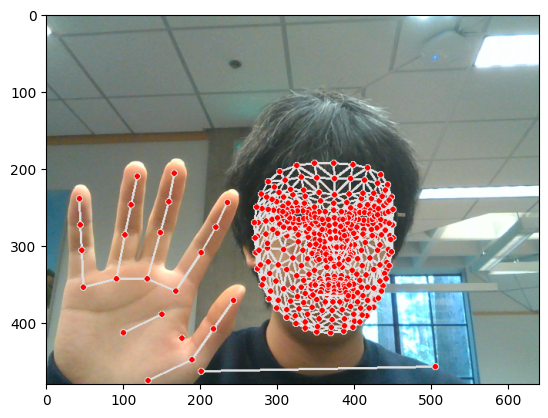

In [42]:
draw_landmarks(image, results)
# draw_landmarks doesn't return the image, but applies the landmark visualizations to the image
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))